# MODEL SELECTION

### Model Selection: Comparative Analysis and Optimal Choice

Within a **5-fold cross-validation framework**, repeated **100 times**, four classification algorithms were evaluated: **Logistic Regression, Support Vector Machine (SVM), K-Nearest Neighbors (KNN), and Random Forest**. To ensure an impartial and robust evaluation, **Synthetic Minority Over-sampling Technique (SMOTE)** was applied exclusively to training folds, following the approach described in the feature engineering section. Conversely, test data were scaled and transformed using the same **scaler and PCA model** derived from the training set, in accordance with best preprocessing practices.

The distribution of obtained metrics allowed **SVM** to be identified as the most performant model, not only in terms of accuracy but also from a computational perspective. This choice is particularly advantageous for a **machine learning project in production**, as SVM offers:
- **Compact model representation**: Unlike **Random Forest**, which requires storing multiple decision trees, or **KNN**, which needs access to the full dataset for predictions, SVM retains only a limited set of **support vectors**. This significantly reduces the storage footprint and facilitates model management.
- **Fast inference**: SVM applies a precomputed decision function directly, eliminating the need for an exhaustive comparison with training data, as required in **KNN**. This ensures **efficient predictions** even on large datasets, making it ideal for production environments where speed is critical.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

In [2]:
data = pd.read_csv('../data/raw/Pistachio_16_Features_Dataset.csv')

In [3]:
del data['id']

data.replace({'Kirmizi_Pistachio': 0, 'Siit_Pistachio' : 1 }, inplace=True)

X = data.iloc[:, 0:16]
columns = X.columns.to_list()

y = data[["Class"]]

In [4]:
sensitivity_scores_RF=[]
f1_scores_RF=[]
precision_scores_RF=[]
auc_scores_RF=[]
specificity_scores_RF=[]
accuracy_scores_RF=[]

for i in range(1,101):
    
    kf = StratifiedKFold(n_splits=5, random_state=i, shuffle =True)

    y_pred = pd.DataFrame(index=X.index, columns=['Prediction'])
        
    for train_index, test_index in kf.split(X,y):
    
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
        
        # Oversampling using SMOTE
        sm = SMOTE(random_state=i)
        X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)
        
        # Standardization
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_oversampled)
        X_test_scaled = scaler.transform(X_test)
        
        # PCA transformation
        pca = PCA(n_components=5)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)

        # Model training
        rf = RandomForestClassifier(n_estimators=61, criterion="gini", max_depth=None, max_features="sqrt", bootstrap=True, random_state=i)
        rf.fit(X_train_pca, y_train_oversampled)
        
        # Model prediction
        y_pred.loc[test_index, 'Prediction'] = rf.predict(X_test_pca)
        
    y_true = y['Class'].astype(int)
    y_pred = y_pred['Prediction'].astype(int)
    
    accuracy_scores_RF.append(accuracy_score(y_true, y_pred))
    sensitivity_scores_RF.append(recall_score(y_true, y_pred, pos_label=1, average = 'binary'))
    f1_scores_RF.append(f1_score(y_true, y_pred, pos_label=1, average = 'binary'))
    specificity_scores_RF.append(recall_score(y_true, y_pred, pos_label=0, average = 'binary'))
    precision_scores_RF.append(precision_score(y_true, y_pred, pos_label=1, average = 'binary'))
    auc_scores_RF.append(roc_auc_score(y_true, y_pred))

print("\nAccuracy Score (%):", round(np.mean(accuracy_scores_RF)*100,2),  u"\u00b1", round(np.std(accuracy_scores_RF)*100,2))
print("Sensitivity Score (%):", round(np.mean(sensitivity_scores_RF)*100,2), u"\u00b1", round(np.std(sensitivity_scores_RF)*100,2))
print("Specificity Score (%):", round(np.mean(specificity_scores_RF)*100,2), u"\u00b1", round(np.std(specificity_scores_RF)*100,2))
print("Precision Score (%):", round(np.mean(precision_scores_RF)*100,2), u"\u00b1", round(np.std(precision_scores_RF)*100,2))
print("F1 Score (%):", round(np.mean(f1_scores_RF)*100,2),  u"\u00b1", round(np.std(f1_scores_RF)*100,2))
print("AUC Score (%):", round(np.mean(auc_scores_RF)*100,2),  u"\u00b1", round(np.std(auc_scores_RF)*100,2))


Accuracy Score (%): 86.28 ± 0.33
Sensitivity Score (%): 85.09 ± 0.55
Specificity Score (%): 87.17 ± 0.42
Precision Score (%): 83.14 ± 0.46
F1 Score (%): 84.1 ± 0.38
AUC Score (%): 86.13 ± 0.34


In [5]:
sensitivity_scores_KNN = []
f1_scores_KNN = []
precision_scores_KNN = []
auc_scores_KNN = []
specificity_scores_KNN = []
accuracy_scores_KNN = []

for i in range(1, 101):
   
    kf = StratifiedKFold(n_splits=5, random_state=i, shuffle=True)

    y_pred = pd.DataFrame(index=X.index, columns=['Prediction'])

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()

        # Oversampling using SMOTE
        sm = SMOTE(random_state=i)
        X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)

        # Standardization
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_oversampled)
        X_test_scaled = scaler.transform(X_test)

        # PCA transformation
        pca = PCA(n_components=5)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)

        # Model training
        knn = KNeighborsClassifier(n_neighbors=11, metric = 'euclidean')
        knn.fit(X_train_pca, y_train_oversampled)

        # Model prediction
        y_pred.loc[test_index, 'Prediction'] = knn.predict(X_test_pca)

    y_true = y['Class'].astype(int)
    y_pred = y_pred['Prediction'].astype(int)

    accuracy_scores_KNN.append(accuracy_score(y_true, y_pred))
    sensitivity_scores_KNN.append(recall_score(y_true, y_pred, pos_label=1, average='binary'))
    f1_scores_KNN.append(f1_score(y_true, y_pred, pos_label=1, average='binary'))
    specificity_scores_KNN.append(recall_score(y_true, y_pred, pos_label=0, average='binary'))
    precision_scores_KNN.append(precision_score(y_true, y_pred, pos_label=1, average='binary'))
    auc_scores_KNN.append(roc_auc_score(y_true, y_pred))

print("\nAccuracy Score (%):", round(np.mean(accuracy_scores_KNN)*100,2),  u"\u00b1", round(np.std(accuracy_scores_KNN)*100,2))
print("Sensitivity Score (%):", round(np.mean(sensitivity_scores_KNN)*100,2), u"\u00b1", round(np.std(sensitivity_scores_KNN)*100,2))
print("Specificity Score (%):", round(np.mean(specificity_scores_KNN)*100,2), u"\u00b1", round(np.std(specificity_scores_KNN)*100,2))
print("Precision Score (%):", round(np.mean(precision_scores_KNN)*100,2), u"\u00b1", round(np.std(precision_scores_KNN)*100,2))
print("F1 Score (%):", round(np.mean(f1_scores_KNN)*100,2),  u"\u00b1", round(np.std(f1_scores_KNN)*100,2))
print("AUC Score (%):", round(np.mean(auc_scores_KNN)*100,2),  u"\u00b1", round(np.std(auc_scores_KNN)*100,2))



Accuracy Score (%): 86.44 ± 0.33
Sensitivity Score (%): 86.32 ± 0.48
Specificity Score (%): 86.53 ± 0.41
Precision Score (%): 82.66 ± 0.45
F1 Score (%): 84.45 ± 0.37
AUC Score (%): 86.42 ± 0.33


In [6]:
sensitivity_scores_SVM = []
f1_scores_SVM = []
precision_scores_SVM = []
auc_scores_SVM = []
specificity_scores_SVM = []
accuracy_scores_SVM = []

for i in range(1, 101):
    
    kf = StratifiedKFold(n_splits=5, random_state=i, shuffle=True)

    y_pred = pd.DataFrame(index=X.index, columns=['Prediction'])

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()

        # Oversampling using SMOTE
        sm = SMOTE(random_state=i)
        X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)

        # Standardization
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_oversampled)
        X_test_scaled = scaler.transform(X_test)

        # PCA transformation
        pca = PCA(n_components=5)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)

        # Model training
        svm = SVC(C=10, kernel='rbf', gamma='scale')
        svm.fit(X_train_pca, y_train_oversampled)

        # Model prediction
        y_pred.loc[test_index, 'Prediction'] = svm.predict(X_test_pca)

    y_true = y['Class'].astype(int)
    y_pred = y_pred['Prediction'].astype(int)

    accuracy_scores_SVM.append(accuracy_score(y_true, y_pred))
    sensitivity_scores_SVM.append(recall_score(y_true, y_pred, pos_label=1, average='binary'))
    f1_scores_SVM.append(f1_score(y_true, y_pred, pos_label=1, average='binary'))
    specificity_scores_SVM.append(recall_score(y_true, y_pred, pos_label=0, average='binary'))
    precision_scores_SVM.append(precision_score(y_true, y_pred, pos_label=1, average='binary'))
    auc_scores_SVM.append(roc_auc_score(y_true, y_pred))

print("\nAccuracy Score (%):", round(np.mean(accuracy_scores_SVM)*100,2),  u"\u00b1", round(np.std(accuracy_scores_SVM)*100,2))
print("Sensitivity Score (%):", round(np.mean(sensitivity_scores_SVM)*100,2), u"\u00b1", round(np.std(sensitivity_scores_SVM)*100,2))
print("Specificity Score (%):", round(np.mean(specificity_scores_SVM)*100,2), u"\u00b1", round(np.std(specificity_scores_SVM)*100,2))
print("Precision Score (%):", round(np.mean(precision_scores_SVM)*100,2), u"\u00b1", round(np.std(precision_scores_SVM)*100,2))
print("F1 Score (%):", round(np.mean(f1_scores_SVM)*100,2),  u"\u00b1", round(np.std(f1_scores_SVM)*100,2))
print("AUC Score (%):", round(np.mean(auc_scores_SVM)*100,2),  u"\u00b1", round(np.std(auc_scores_SVM)*100,2))



Accuracy Score (%): 87.14 ± 0.27
Sensitivity Score (%): 87.01 ± 0.42
Specificity Score (%): 87.23 ± 0.37
Precision Score (%): 83.52 ± 0.4
F1 Score (%): 85.23 ± 0.31
AUC Score (%): 87.12 ± 0.27


In [7]:
sensitivity_scores_LR = []
f1_scores_LR = []
precision_scores_LR = []
auc_scores_LR = []
specificity_scores_LR = []
accuracy_scores_LR = []

for i in range(1, 101):
    
    kf = StratifiedKFold(n_splits=5, random_state=i, shuffle=True)

    y_pred = pd.DataFrame(index=X.index, columns=['Prediction'])

    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()

        # Oversampling using SMOTE
        sm = SMOTE(random_state=i)
        X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train)

        # Standardization
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_oversampled)
        X_test_scaled = scaler.transform(X_test)

        # PCA transformation
        pca = PCA(n_components=5)
        X_train_pca = pca.fit_transform(X_train_scaled)
        X_test_pca = pca.transform(X_test_scaled)

        # Model training
        lr = LogisticRegression(penalty = 'l2',dual=False, C=1, fit_intercept=True, intercept_scaling=True,solver='liblinear', random_state=i)
        lr.fit(X_train_pca, y_train_oversampled)

        # Model prediction
        y_pred.loc[test_index, 'Prediction'] = lr.predict(X_test_pca)

    y_true = y['Class'].astype(int)
    y_pred = y_pred['Prediction'].astype(int)

    accuracy_scores_LR.append(accuracy_score(y_true, y_pred))
    sensitivity_scores_LR.append(recall_score(y_true, y_pred, pos_label=1, average='binary'))
    f1_scores_LR.append(f1_score(y_true, y_pred, pos_label=1, average='binary'))
    specificity_scores_LR.append(recall_score(y_true, y_pred, pos_label=0, average='binary'))
    precision_scores_LR.append(precision_score(y_true, y_pred, pos_label=1, average='binary'))
    auc_scores_LR.append(roc_auc_score(y_true, y_pred))

print("\nAccuracy Score (%):", round(np.mean(accuracy_scores_LR)*100,2),  u"\u00b1", round(np.std(accuracy_scores_LR)*100,2))
print("Sensitivity Score (%):", round(np.mean(sensitivity_scores_LR)*100,2), u"\u00b1", round(np.std(sensitivity_scores_LR)*100,2))
print("Specificity Score (%):", round(np.mean(specificity_scores_LR)*100,2), u"\u00b1", round(np.std(specificity_scores_LR)*100,2))
print("Precision Score (%):", round(np.mean(precision_scores_LR)*100,2), u"\u00b1", round(np.std(precision_scores_LR)*100,2))
print("F1 Score (%):", round(np.mean(f1_scores_LR)*100,2),  u"\u00b1", round(np.std(f1_scores_LR)*100,2))
print("AUC Score (%):", round(np.mean(auc_scores_LR)*100,2),  u"\u00b1", round(np.std(auc_scores_LR)*100,2))


Accuracy Score (%): 86.45 ± 0.16
Sensitivity Score (%): 85.79 ± 0.26
Specificity Score (%): 86.95 ± 0.22
Precision Score (%): 83.01 ± 0.24
F1 Score (%): 84.38 ± 0.18
AUC Score (%): 86.37 ± 0.16


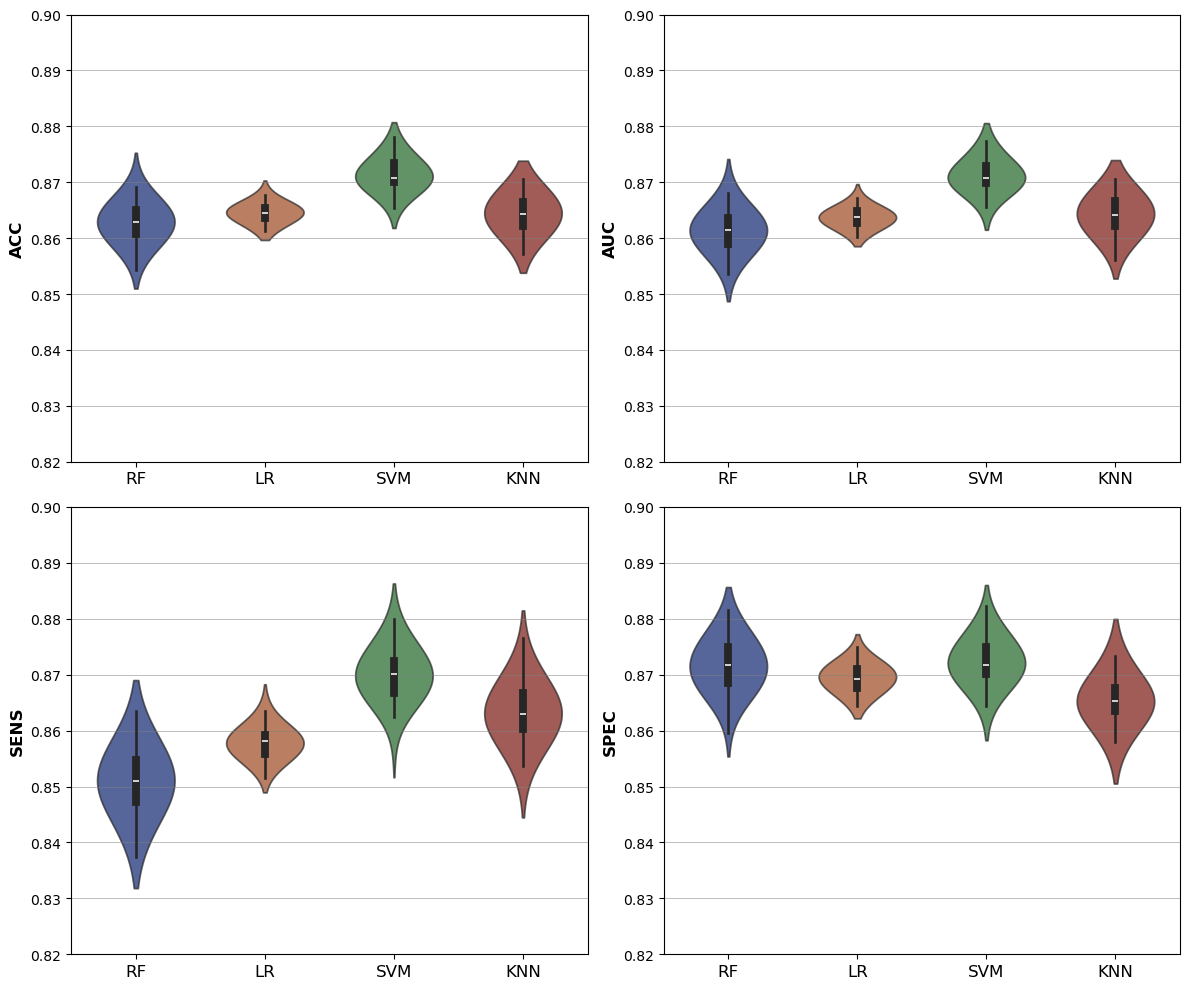

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))


sns.violinplot([accuracy_scores_RF, accuracy_scores_LR, accuracy_scores_SVM, accuracy_scores_KNN], 
               palette="dark", alpha=0.7, bw=1, inner='box', width=0.6, cut=1, ax=axes[0, 0])
axes[0, 0].set_xticks([0, 1, 2, 3])
axes[0, 0].set_xticklabels(['RF', 'LR', 'SVM', 'KNN'], fontsize=12)
axes[0, 0].set_ylabel('ACC', fontsize=12, weight='bold')
axes[0, 0].set_ylim(0.82, 0.9)
axes[0, 0].grid(color='gray', linewidth=0.6, axis='y', alpha=0.6)


sns.violinplot([auc_scores_RF, auc_scores_LR, auc_scores_SVM, auc_scores_KNN], 
               palette="dark", alpha=0.7, bw=1, inner='box', width=0.6, cut=1, ax=axes[0, 1])
axes[0, 1].set_xticks([0, 1, 2, 3])
axes[0, 1].set_xticklabels(['RF', 'LR', 'SVM', 'KNN'], fontsize=12)
axes[0, 1].set_ylabel('AUC', fontsize=12, weight='bold')
axes[0, 1].set_ylim(0.82, 0.9)
axes[0, 1].grid(color='gray', linewidth=0.6, axis='y', alpha=0.6)


sns.violinplot([sensitivity_scores_RF, sensitivity_scores_LR, sensitivity_scores_SVM, sensitivity_scores_KNN], 
               palette="dark", alpha=0.7, bw=1, inner='box', width=0.6, cut=1, ax=axes[1, 0])
axes[1, 0].set_xticks([0, 1, 2, 3])
axes[1, 0].set_xticklabels(['RF', 'LR', 'SVM', 'KNN'], fontsize=12)
axes[1, 0].set_ylabel('SENS', fontsize=12, weight='bold')
axes[1, 0].set_ylim(0.82, 0.9)
axes[1, 0].grid(color='gray', linewidth=0.6, axis='y', alpha=0.6)


sns.violinplot([specificity_scores_RF, specificity_scores_LR, specificity_scores_SVM, specificity_scores_KNN], 
               palette="dark", alpha=0.7, bw=1, inner='box', width=0.6, cut=1, ax=axes[1, 1])
axes[1, 1].set_xticks([0, 1, 2, 3])
axes[1, 1].set_xticklabels(['RF', 'LR', 'SVM', 'KNN'], fontsize=12)
axes[1, 1].set_ylabel('SPEC', fontsize=12, weight='bold')
axes[1, 1].set_ylim(0.82, 0.9)
axes[1, 1].grid(color='gray', linewidth=0.6, axis='y', alpha=0.6)


plt.tight_layout()
plt.show()
